In [1]:
import pandas as pd
import pandas_datareader as data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from datetime import datetime, timedelta
import time

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

### Download data from Binance api

In [2]:
def get_data(coin, tick_interval = '1h'):
    #Download data from binance brooker
    try:
        market = coin+'USDT' #coins needs to be in pair with other coin. I use USDT that is thether backed by an equivalent amount of U.S. dollars. It's price is pegged to 1 USD.
        url = 'https://api.binance.com/api/v3/klines?symbol='+market+'&interval='+tick_interval
        data = requests.get(url).json() #request data from url specified above and store as json file
        data = pd.DataFrame(data) #convert it to DataFrame for easier manipulation
        data = data.astype(float) #convert format of data to float (binance returns data as strings)
        #first column is datetime saved as UNIX value. I want standard pandas datetime format so that is what I do in line below.
        data[0] = pd.to_datetime(pd.to_datetime(data[0], unit = 'ms', utc = True).dt.tz_convert('Europe/Dublin').dt.strftime('%Y-%m-%d %H:%M:%S'))
        data = data.iloc[:, [0, 4]].rename(columns={0: 'Datetime', 4: coin}) #Keep only first ('Datetime') and fifth ('Close') column and rename them accordingly
        data.set_index('Datetime', inplace=True) #set Datetime column as index
        
        return data
    
    except Exception as e:
        print(e) #print exception if any occurs
        
        
#list of coins that I want to analyze
coins = ['BTC', 'ETH', 'ADA', 'XRP', 'SOL', 'DOT', 'DOGE', 'LUNA', 'UNI', 'BUSD', 'AVAX', 'LTC', 'LINK', 'BCH', 'ALGO', 
         'SHIB', 'MATIC', 'XLM', 'FIL', 'ATOM', 'AXS', 'VET', 'TRX', 'ETC', 'FTT', 'DAI', 'THETA', 'XTZ', 'EGLD']

### Create dashboard with heatmaps and overal market movement for selected coins

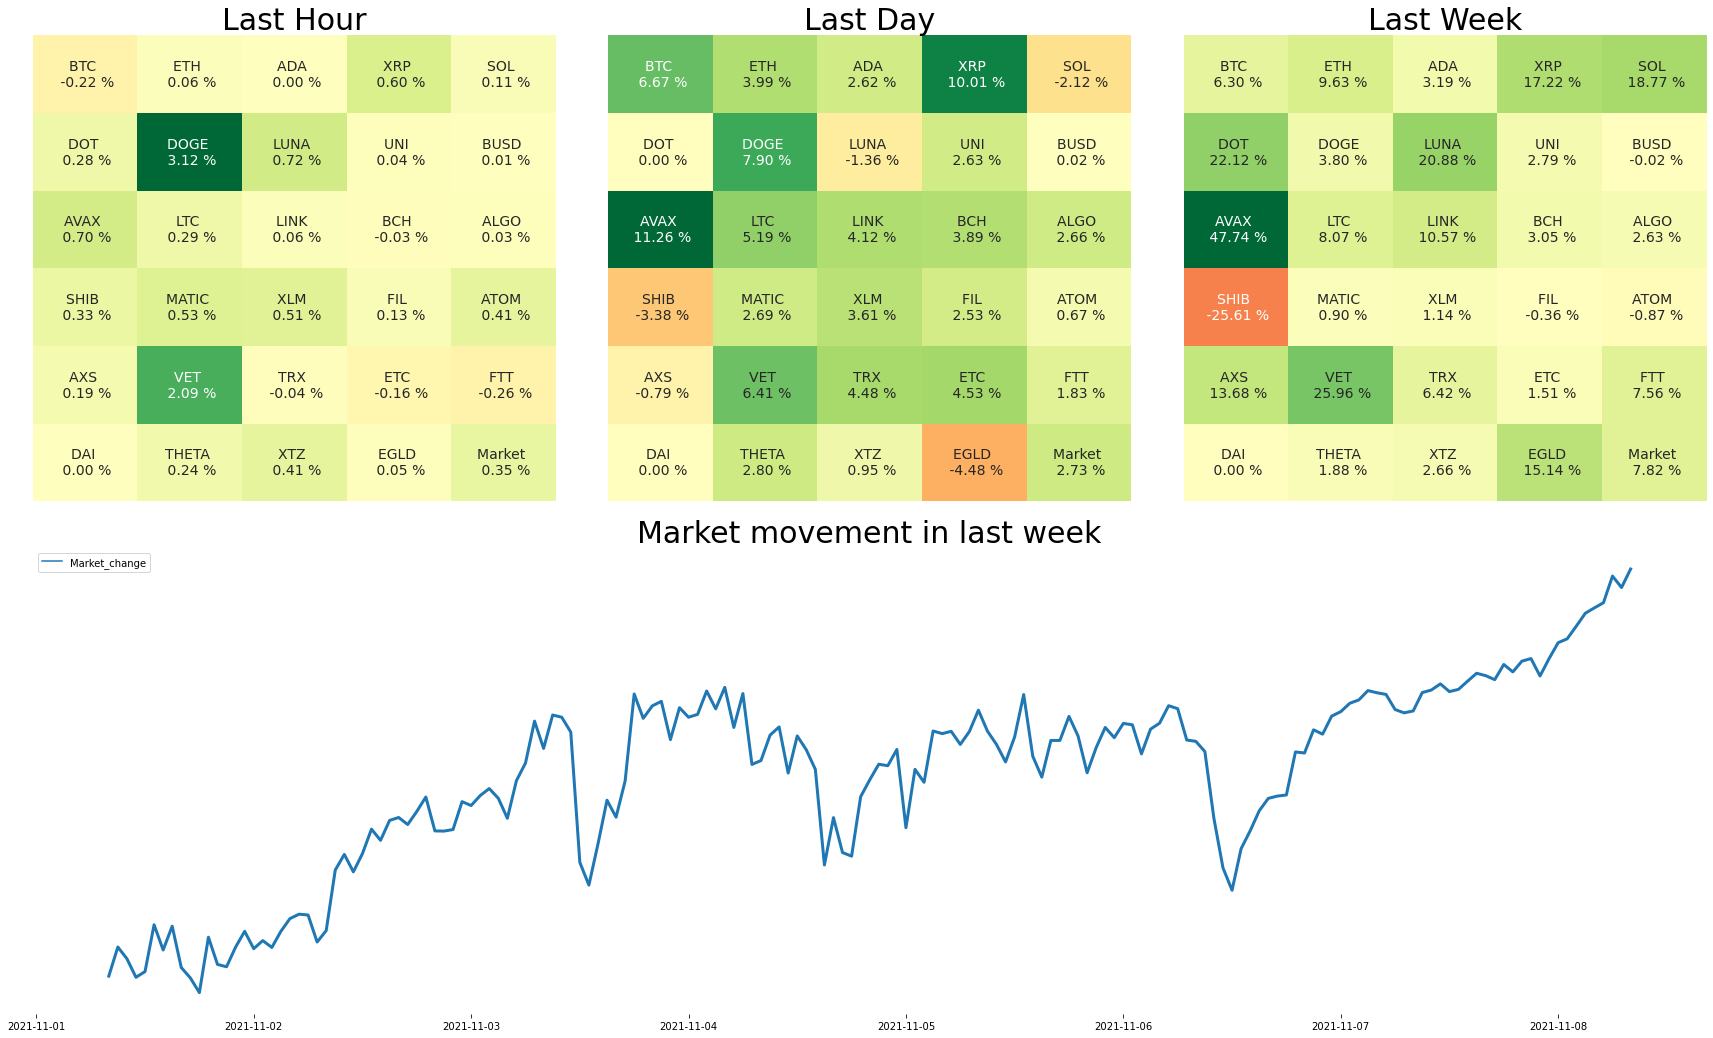

In [3]:
data = [] #empty list where I store data for every coin pair

for coin in coins: #itterate through coins
    if len(data) == 0: #for first coin I simply run get_data function
        data = get_data(coin = coin, tick_interval = '1h')
    else:
        data[coin] = get_data(coin = coin, tick_interval = '1h')[coin] #then for every other coin we need to specify column name where it will add new data

coins = coins + ['Market'] #I want to include Overall Market in heatmap, that's why I add this in to list of coins here

fig = plt.figure(figsize=(30, 18))
gs = fig.add_gridspec(nrows=2, ncols=3, wspace = 0.1, hspace = 0.1) #define how plots will be organized in grid

#LAST HOUR
last_hour_pct = data.pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change in data for last hour (I have hourly data so simply take last row)
last_hour_pct['Market'] = last_hour_pct.mean() #I want overall market movement so I just calculate mean of each pct movement. You can add more sophisticated calculation
pct_diff_h = ((np.asarray(last_hour_pct)).reshape(6, 5)) #I have 29 coins and also Market, that makes 30 datapoints that I want to plot as 6x5 heat map
#to show coin name toghether with percentual change we need to create labels in 6x5 array containing this data. (\n splits data in to 2 rows)
labels_h = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_h)
            for coins, pct_diff_h in zip(coins, pct_diff_h.flatten())])).reshape(6, 5)

ax1 = fig.add_subplot(gs[0 , 0]) #specify the position of first plot in the grid
sns.heatmap(pct_diff_h, annot = labels_h, fmt="", cmap='RdYlGn', ax = ax1, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax1.set_title('Last Hour', size = 30)
ax1.tick_params(left=False, bottom=False)

#LAST DAY
last_day_pct = data.iloc[[-25, -1]].pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change for last day (25 hours gets us to the same hour yesterday)
last_day_pct['Market'] = last_day_pct.mean()
pct_diff_d = ((np.asarray(last_day_pct)).reshape(6, 5))
labels_d = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_d)
            for coins, pct_diff_d in zip(coins, pct_diff_d.flatten())])).reshape(6, 5)

ax2 = fig.add_subplot(gs[0 , 1])
sns.heatmap(pct_diff_d, annot = labels_d, fmt="", cmap='RdYlGn', ax = ax2, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax2.set_title('Last Day', size = 30)
ax2.tick_params(left=False, bottom=False)

#LAST WEEK
last_week_pct = data.iloc[[-169, -1]].pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change for last week (169 hours is 7 days and 1 hour)
last_week_pct['Market'] = last_week_pct.mean()
pct_diff_w = ((np.asarray(last_week_pct)).reshape(6, 5))
labels_w = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_w)
            for coins, pct_diff_w in zip(coins, pct_diff_w.flatten())])).reshape(6, 5)

ax3 = fig.add_subplot(gs[0 , 2])
sns.heatmap(pct_diff_w, annot = labels_w, fmt="", cmap='RdYlGn', ax = ax3, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax3.set_title('Last Week', size = 30)
ax3.tick_params(left=False, bottom=False)

#OVERALL MARKET
pct = data.pct_change() #calculate percentual change for every column in data dataframe
pct['Market_change'] = pct.mean(axis = 1) #then calculate mean of every row and save this values in new column 'Market_change'
pct['Market'] = pct['Market_change'].cumsum() #and finally calculate cumulative sum of this pct changes to get market movement that I can plot

ax4 = fig.add_subplot(gs[1 , 0:])
sns.lineplot(data = pct[['Market_change']].cumsum().iloc[-169:], lw = 3, ax = ax4)
ax4.set_title('Market movement in last week', size = 30)
ax4.set(xlabel=None)
ax4.axes.yaxis.set_visible(False)

plt.show()

### Report for selected coin

In [4]:
coin = 'ETH'

In [5]:
def coin_analysis(coin):
    last_year = get_data(coin, tick_interval = '1d')[-365:] #download data for last 365 days
    last_year['pct_change'] = last_year[coin].pct_change() #add column with percentual change per day
    profit_days = last_year[last_year['pct_change'] >= 0] #filter out only profit days
    loss_days = last_year[last_year['pct_change'] < 0] #and also lossing days

    #Drawdown
    valley = np.argmax(np.maximum.accumulate(last_year[coin]) - last_year[coin]) #find maximum distance between maximum price coin had so far - actual price
    peak = np.argmax(last_year[coin][:valley]) #find maximum price coin had from start to moment when valley formed

    fig = plt.figure(figsize=(30, 10))
    gs = fig.add_gridspec(nrows=2, ncols=2, wspace = 0, hspace = 0.1) #define how plots will be organized in grid

    ax1 = fig.add_subplot(gs[0 , 0:]).get_xaxis().set_visible(False) #specify the position of first plot in the grid
    plt.plot(last_year[coin])
    plt.plot(last_year.index[peak], last_year[coin][peak], 'o', color = 'Green', markersize = 10)
    plt.plot(last_year.index[valley], last_year[coin][valley], 'o', color = 'Red', markersize = 10)
    plt.title(coin+'USDT', size = 18, fontweight='bold')

    ax2 = fig.add_subplot(gs[1 , 0:]) #specify the position of first plot in the grid
    plt.bar(last_year.index, height = last_year['pct_change'], color=['coral' if v < 0 else 'limegreen' for v in last_year['pct_change']])
    plt.title('Daily movement', fontweight='bold')
    plt.show()

    print('\n')
    print('Number of profit days:', len(profit_days))
    print('Number of losing days:', len(loss_days))
    print('Average profit day:', round(profit_days['pct_change'].mean() * 100, 2), '%')
    print('Average losing day:', round(loss_days['pct_change'].mean() * 100, 2), '%')
    print('Maximum Drawdown:', round(((last_year[coin][peak] - last_year[coin][valley]) / last_year[coin][peak])*100, 2), '%')
    print('YTD profit:', round((last_year[coin][-1] - last_year[coin][0]) / last_year[coin][0] * 100, 2), '%')

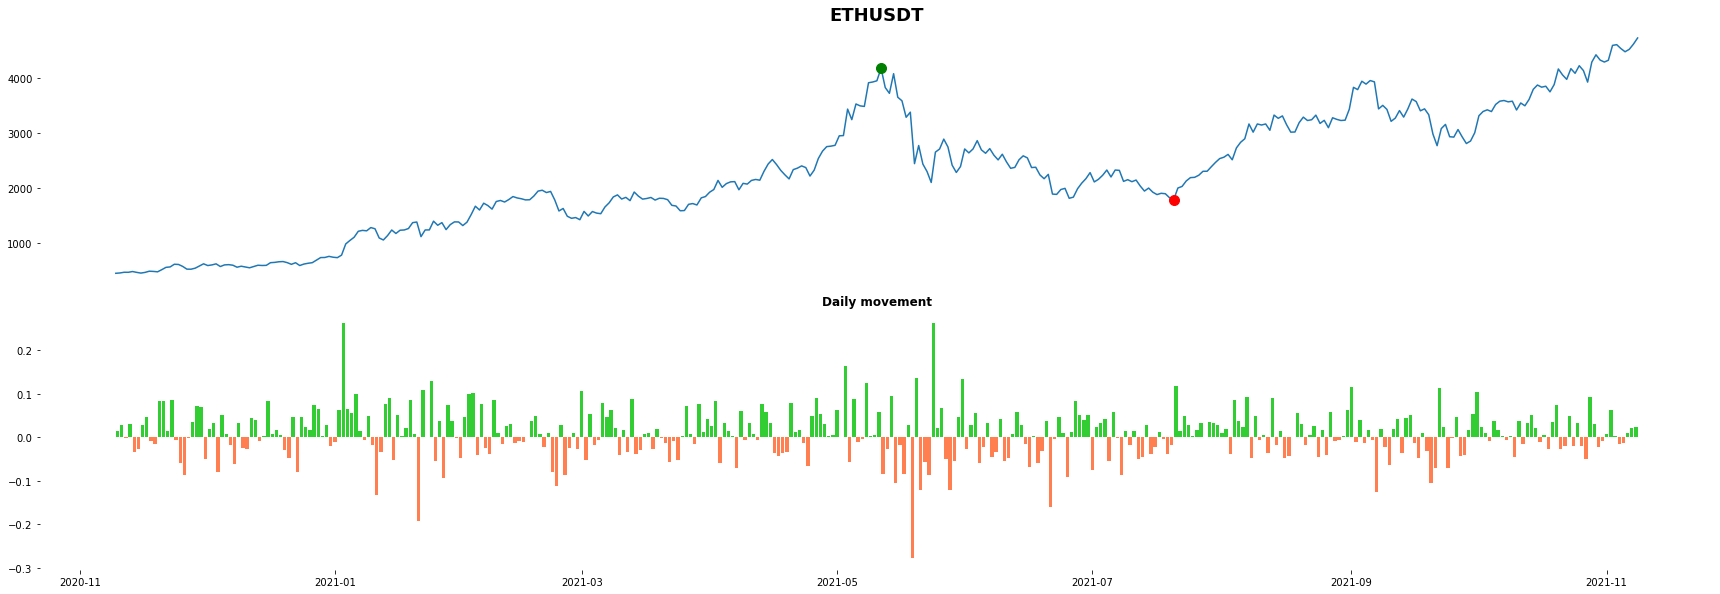



Number of profit days: 212
Number of losing days: 152
Average profit day: 4.36 %
Average losing day: -4.13 %
Maximum Drawdown: 57.2 %
YTD profit: 963.43 %


In [6]:
coin_analysis(coin)

### Monthly return
We can see historical returns by individual months so we can at least know what to expect in future

Data from: 2017-08-01


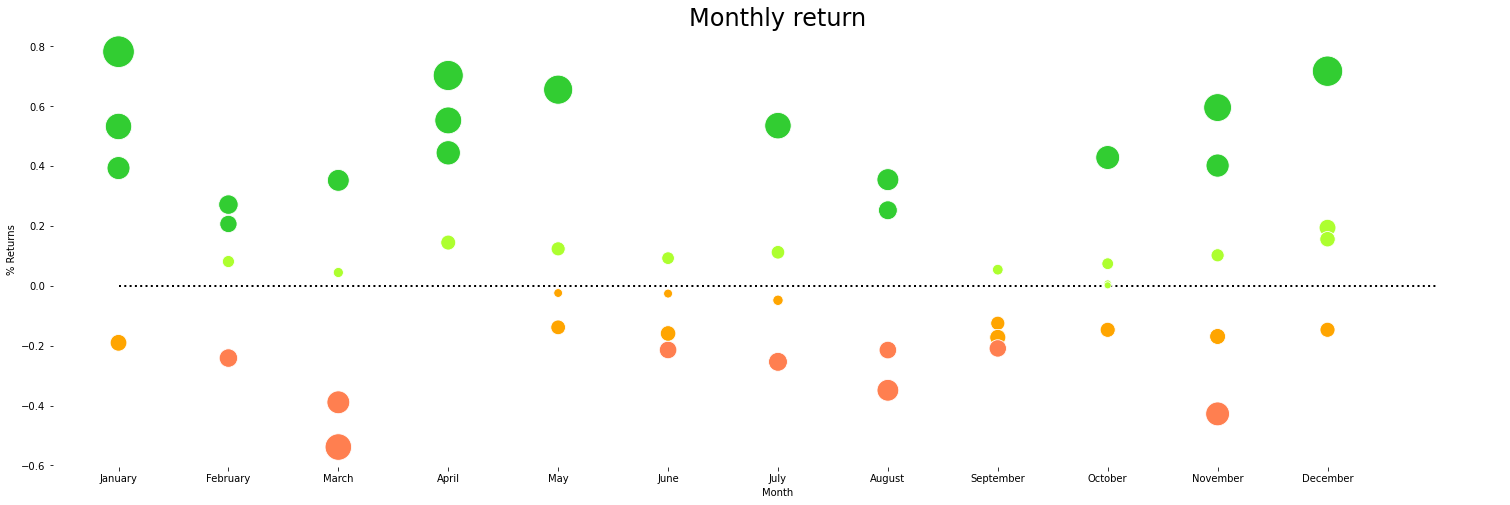

Maximum POSITIVE monthly return: 78.23 %
Average POSITIVE monthly return: 31.23 %
Median of POSITIVE monthly returns: 26.2 % 

Maximum NEGATIVE monthly return: -53.85 %
Average NEGATIVE monthly return: -20.73 %
Median of NEGATIVE monthly returns: -17.22 %


In [7]:
df = get_data(coin, tick_interval = '1M') #download monthly data
print('Data from:', df.index.date[0]) #print first available date
df['pct_change'] = df[coin].pct_change() #add new column with percentual change between previous and current month
'''
Now to be able to set different colors by return we can create another column where are categories.
If percentual change is lower then -0.2 or -20%, then value in pct_cat is -2
If price is less then 0 (but higher then -0.2) value is -1
If price greater then 0.2, value is 1
If price is greater or equal to 0 (but less than 0.2), value is 2
'''
df['pct_cat'] = np.where(df['pct_change'] < -0.2, -2, 
                        np.where(df['pct_change'] < 0, -1, 
                                np.where(df['pct_change'] >= 0.2, 1, 
                                        np.where(df['pct_change'] >= 0, 2, 0)))) 
df['month_number'] = df.index.month #store month number as integer here so we can order dataframe by month
df.index =  df.index.month_name() #for index we need only month name
df.sort_values(by=['month_number'], inplace = True) #sort dataframe by month number

#and finaly scatter plot of monthly returns
plt.figure(figsize = (26, 8))
sns.scatterplot(x = df.index, y = df['pct_change'], size = abs(df['pct_change']), hue = df['pct_cat'], palette= ['coral', 'orange', 'black', 'limegreen', 'greenyellow'], 
                sizes=(50, 1000), legend = False, zorder=100)
plt.hlines(xmin = 0, xmax = len(set(df.index)), y = 0, color='k', linewidth=2, ls = 'dotted')
plt.title('Monthly return', size = 24)
plt.xlabel("Month")
plt.ylabel("% Returns")

plt.show()

print('Maximum POSITIVE monthly return:', round(df['pct_change'].max() * 100, 2), '%')
print('Average POSITIVE monthly return:', round(df[df['pct_change'] > 0]['pct_change'].mean() * 100, 2), '%')
print('Median of POSITIVE monthly returns:', round(df[df['pct_change'] > 0]['pct_change'].median() * 100, 2), '% \n')
print('Maximum NEGATIVE monthly return:', round(df['pct_change'].min() * 100, 2), '%')
print('Average NEGATIVE monthly return:', round(df[df['pct_change'] < 0]['pct_change'].mean() * 100, 2), '%')
print('Median of NEGATIVE monthly returns:', round(df[df['pct_change'] < 0]['pct_change'].median() * 100, 2), '%')

### Daily return

Data from: 2020-06-27


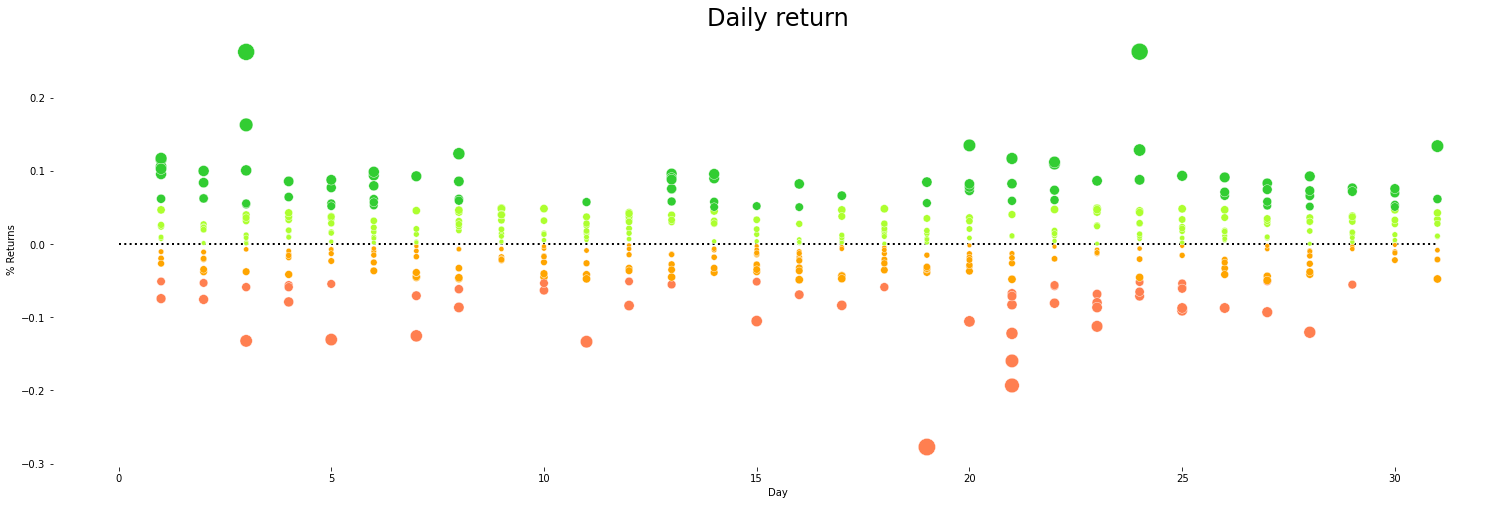

Maximum POSITIVE daily return: 26.33 %
Average POSITIVE daily return: 3.98 %
Median of POSITIVE daily returns: 3.16 %

Maximum NEGATIVE daily return: -27.74 %
Average NEGATIVE daily return: -3.8 %
Median of NEGATIVE daily returns: -2.84 %


In [8]:
df = get_data(coin, tick_interval = '1d') #download daily data
print('Data from:', df.index.date[0]) #print first available date
df['pct_change'] = df[coin].pct_change() #add new column with percentual change between previous and current day
df['pct_cat'] = np.where(df['pct_change'] < -0.05, -2, 
                        np.where(df['pct_change'] < 0, -1, 
                                np.where(df['pct_change'] >= 0.05, 1, 
                                        np.where(df['pct_change'] >= 0, 2, 0)))) 
df['day_number'] = df.index.day #store day number as integer here so we can order dataframe by day
df.index =  df.index.day #for index we need only day number
df.sort_values(by=['day_number'], inplace = True) #sort dataframe by day number

#and finaly scatter plot of daily returns
plt.figure(figsize = (26, 8))
sns.scatterplot(x = df.index, y = df['pct_change'], size = abs(df['pct_change']), hue = df['pct_cat'], palette= ['coral', 'orange', 'black', 'limegreen', 'greenyellow'], 
                sizes=(20, 300), legend = False, zorder=100)
plt.hlines(xmin = 0, xmax = len(set(df.index)), y = 0, color='k', linewidth=2, ls = 'dotted')
plt.title('Daily return', size = 24)
plt.xlabel("Day")
plt.ylabel("% Returns")

plt.show()

print('Maximum POSITIVE daily return:', round(df['pct_change'].max() * 100, 2), '%')
print('Average POSITIVE daily return:', round(df[df['pct_change'] > 0]['pct_change'].mean() * 100, 2), '%')
print('Median of POSITIVE daily returns:', round(df[df['pct_change'] > 0]['pct_change'].median() * 100, 2), '%\n')
print('Maximum NEGATIVE daily return:', round(df['pct_change'].min() * 100, 2), '%')
print('Average NEGATIVE daily return:', round(df[df['pct_change'] < 0]['pct_change'].mean() * 100, 2), '%')
print('Median of NEGATIVE daily returns:', round(df[df['pct_change'] < 0]['pct_change'].median() * 100, 2), '%')